In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from mdp_description import MDPDescription
from new_mdp_description import MDPDescription2
from scipy.special import rel_entr
from utils import project_omega,compute_stationary_distribution, unit_vector, angle_between, gram_schmidt
import matplotlib.ticker as mticker
N_SIMS = 10
N_VALS = 1
NS = [5]
NEPS = 10**np.geomspace(-4, np.log10(0.95), 50)#np.linspace(1e-3, 0.9, 100)
NA = [4]
discount_factor = 0.99
np.random.seed(2)
tol_values = [1e-12]#10**np.geomspace(-12, -5, N_VALS)

def TV(p,q):
    return np.sum(np.abs(p-q)) * 0.5

def CE(x, c=1.96):
    return x.mean(0), c * x.std(0) / np.sqrt(x.shape[0])


import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r'\usepackage{amsmath}',
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage{helvet}',    # set the normal font here
        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
        r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    ]
})


In [16]:
res_U_gen_proj_forced = np.zeros((len(NS), len(NA), N_SIMS, len(NEPS)))
res_U_gen_proj = np.zeros((len(NS), len(NA), N_SIMS, len(NEPS)))
res_U_Qgreedy_proj = np.zeros((len(NS), len(NA), N_SIMS, len(NEPS)))
res_U_soft = np.zeros((len(NS), len(NA), N_SIMS))

res_TV_gen_proj_forced = np.zeros((len(NS), len(NA), N_SIMS, len(NEPS)))
res_TV_gen_proj = np.zeros((len(NS), len(NA), N_SIMS, len(NEPS)))
#res_TV_gen2 = np.zeros((len(NS), len(NA), N_SIMS, len(NEPS)))
res_TV_Qgreedy = np.zeros((len(NS), len(NA), N_SIMS, len(NEPS)))
res_TV_soft = np.zeros((len(NS), len(NA), N_SIMS))
res_U_C = np.zeros((len(NS), len(NA), N_SIMS))
delta_sq_min = np.zeros((len(NS), len(NA), N_SIMS))

for id_ns, ns in enumerate(NS):
    for id_na, na in enumerate(NA):
        for sim in tqdm(range(N_SIMS)):
            while True:
                try:
                    P = np.random.dirichlet(np.ones(ns), size=(ns, na))
                    R = np.random.dirichlet(np.ones(ns), size=(ns, na))
                    mdp = MDPDescription2(P, R, discount_factor, 1)
                    delta_sq_min[id_ns, id_na, sim] = mdp.delta_sq_min
                    omega_gen = mdp.compute_allocation()[0]
                    omega_nav_constr, omega_nav_constr_val = mdp.compute_allocation(navigation_constraints=True)
                    res_U_C[id_ns, id_na, sim] = omega_nav_constr_val             
                    pi_greedy = np.eye(na)[mdp.Q_greedy.argmax(1)]
                    
                    soft_policy = mdp.compute_optimal_soft_policy(0.99, .1)[1]
                    omega_soft = compute_stationary_distribution(soft_policy, P)
                    res_U_soft[id_ns, id_na, sim] = mdp.evaluate_allocation(omega_soft, navigation_constraints=True)
                    res_TV_soft[id_ns, id_na, sim] = TV(omega_soft, omega_nav_constr)
            
                    for id_eps, eps in enumerate(NEPS):
                        # Eps q-greedy
                        
                        Q_eps = eps * np.ones((ns, na)) / (na) + (1-eps) * pi_greedy
                        omega_Q_eps = compute_stationary_distribution(Q_eps, mdp.P)
                        res_U_Qgreedy_proj[id_ns, id_na, sim, id_eps] = mdp.evaluate_allocation(omega_Q_eps, navigation_constraints=True)
                        res_TV_Qgreedy[id_ns, id_na, sim, id_eps] = TV(omega_Q_eps, omega_nav_constr)
                        
                        # Forced projected generative
                        omega_gen_eps = eps * np.ones((ns, na)) / (ns*na) + (1-eps) * omega_gen
                        omega_gen_proj_forced = project_omega(omega_gen_eps, mdp.P, force_policy=True)
                        res_TV_gen_proj_forced[id_ns, id_na, sim, id_eps] = TV(omega_gen_proj_forced, omega_nav_constr)
                        res_U_gen_proj_forced[id_ns, id_na, sim, id_eps] = mdp.evaluate_allocation(omega_gen_proj_forced, navigation_constraints=True)

                        # Unforced projected generative
                        omega_gen_proj = project_omega(omega_gen_eps, mdp.P, force_policy=False)
                        res_TV_gen_proj[id_ns, id_na, sim, id_eps] = TV(omega_gen_proj, omega_nav_constr)
                        res_U_gen_proj[id_ns, id_na, sim, id_eps] = mdp.evaluate_allocation(omega_gen_proj, navigation_constraints=True)
                    break
                except Exception as e:
                    print(e)
                    continue

with open('data_results_comparation.pkl', 'wb') as f:
    pickle.dump({'res_U_gen_proj': res_U_gen_proj, 'res_TV_gen_proj': res_TV_gen_proj,
                 'res_U_gen_proj_forced': res_U_gen_proj_forced, 'res_TV_gen_proj_forced': res_TV_gen_proj_forced,
                 'res_U_C': res_U_C,
                 'res_U_Qgreedy_proj': res_U_Qgreedy_proj, 'res_TV_Qgreedy': res_TV_Qgreedy,
                 'res_U_soft': res_U_soft, 'res_TV_soft': res_TV_soft,
                 'delta_sq_min': delta_sq_min}, f,  protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [01:21<00:00,  8.15s/it]


In [21]:
with open('data_results_comparation.pkl', 'rb') as f:
    data = pickle.load(f)
res_U_gen_proj = data['res_U_gen_proj']
res_U_gen_proj_forced = data['res_U_gen_proj_forced']
res_U_Qgreedy_proj = data['res_U_Qgreedy_proj']
res_TV_gen_proj = data['res_TV_gen_proj']
res_TV_gen_proj_forced = data['res_TV_gen_proj_forced']
res_TV_Qgreedy = data['res_TV_Qgreedy']
res_U_C = data['res_U_C']
delta_sq_min = data['delta_sq_min']
res_U_soft = data['res_U_soft']
res_TV_soft = data['res_TV_soft']


[]

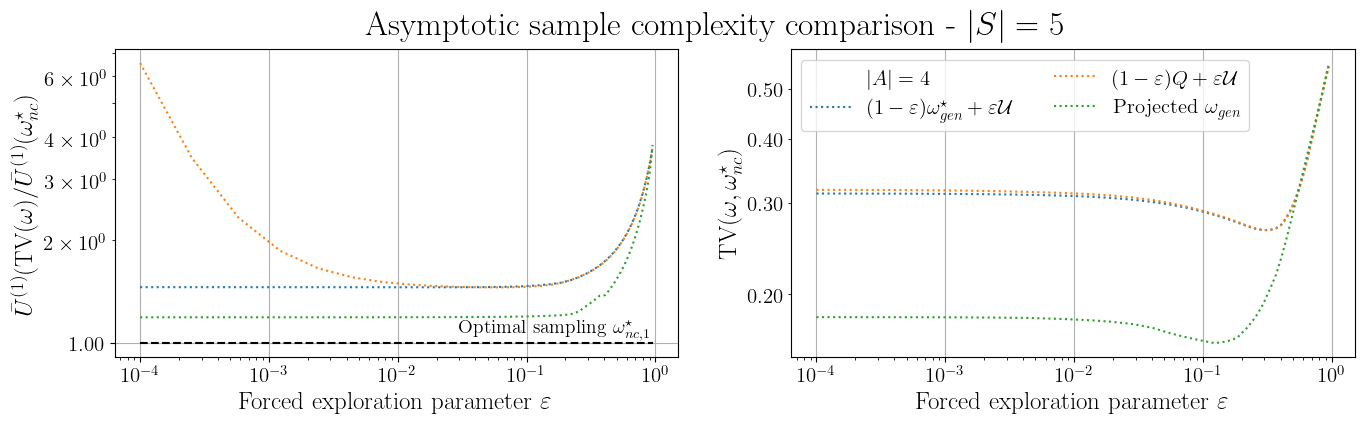

In [23]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

markers = {
    5: '',
    10: ''
}

linestyles = {
    4: 'dotted',
    15: 'solid'
}

for id_ns, ns in enumerate([NS[-1]]):
    for id_na, na in enumerate(NA):
        mu0 = np.median(res_U_C[id_ns, id_na], 0)
        ##
        mu = np.median(res_U_gen_proj_forced[id_ns, id_na] / mu0, 0)
        ax[0].plot(NEPS, mu, label=r'$(1-\varepsilon)\omega_{gen}^\star +\varepsilon {\cal U}$', linestyle=linestyles[na], marker=markers[ns])
        ##
        mu = np.median(res_U_Qgreedy_proj[id_ns, id_na] / mu0, 0)
        ax[0].plot(NEPS, mu, label=r'$(1-\varepsilon)Q+\varepsilon {\cal U}$', linestyle=linestyles[na], marker=markers[ns])
        
        ## Soft
        mu = np.median(res_U_gen_proj[id_ns, id_na] / mu0, 0)
        ax[0].plot(NEPS, mu, label=r'Projected $\omega_{gen}$', linestyle=linestyles[na], marker=markers[ns])
        
        # mu = np.median(res_U_soft[id_ns, id_na] / mu0, 0)
        # ax[0].plot(NEPS, mu * np.ones(len(NEPS)), label=r'soft', linestyle=linestyles[na], marker=markers[ns])

        mu, se = CE(res_TV_gen_proj_forced[id_ns, id_na])
        ax[1].plot(NEPS, mu, linestyle=linestyles[na], marker=markers[ns])
    
        mu, se = CE(res_TV_Qgreedy[id_ns, id_na])
        ax[1].plot(NEPS, mu, linestyle=linestyles[na], marker=markers[ns])
        
        mu, se = CE(res_TV_gen_proj[id_ns, id_na])
        ax[1].plot(NEPS, mu, linestyle=linestyles[na], marker=markers[ns])
        
        #mu, se = CE(res_TV_soft[id_ns, id_na])
        #ax[1].plot(NEPS, mu * np.ones(len(NEPS)), linestyle=linestyles[na], marker=markers[ns])

ax[0].plot(NEPS, 1*np.ones_like(NEPS), 'k--')
ax[0].text(3e-2, 1.07, r'Optimal sampling $\omega_{nc,1}^\star$', fontsize=14)

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].grid()
ax[0].set_xlabel(r'Forced exploration parameter $\varepsilon$')
ax[0].set_ylabel(r'$\bar U^{(1)}({\rm TV}(\omega)/\bar U^{(1)}(\omega_{nc}^\star)$')
ax[0].yaxis.set_major_formatter(mticker.ScalarFormatter())


ax[1].set_xscale('log')
ax[1].grid()
ax[1].set_yscale('log')
#ax[1].set_ylim(0.15, 0.3)
ax[1].set_xlabel(r'Forced exploration parameter $\varepsilon$')
ax[1].set_ylabel(r'${\rm TV}(\omega, \omega_{nc}^\star)$')
ax[1].yaxis.set_minor_formatter(mticker.ScalarFormatter())

h1, l1 = ax[0].get_legend_handles_labels()

#h1.insert(2, plt.plot([],marker="", ls="")[0])
#h1.insert(0, plt.plot([],marker="", ls="")[0])
#l1.insert(2, f'$|A|={NA[1]}$')
#l1.insert(0, f'$|A|={NA[0]}$')
ax[1].legend(h1, l1,  ncols=1)
plt.suptitle(f'Asymptotic sample complexity comparison - $|S|={NS[-1]}$')
#plt.tight_layout()
plt.savefig('plot_random_mdp_comparison_Q.pdf', bbox_inches='tight')
plt.plot()

In [115]:
with open('data_results_comparation.pkl', 'wb') as f:
    pickle.dump({'res_U': res_U, 'res_TV': res_TV}, f,  protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
mdp.compute_optimal_soft_policy(0.99, 0.1)

(array([24.69829444, 24.6585924 , 24.68014368, 24.70692345, 24.7109887 ]),
 array([[0.07230443, 0.05661809, 0.05864786, 0.06253249, 0.06391261,
         0.07655513, 0.07630051, 0.06730098, 0.05215477, 0.0604513 ,
         0.06160212, 0.06378146, 0.07913117, 0.07356905, 0.07513803],
        [0.0678934 , 0.07400663, 0.07869642, 0.04801262, 0.0474403 ,
         0.07109504, 0.08188492, 0.06524472, 0.06161042, 0.09494331,
         0.06600347, 0.06831358, 0.04768575, 0.08512028, 0.04204914],
        [0.06976023, 0.08038673, 0.07355628, 0.07366727, 0.070992  ,
         0.06099625, 0.07623186, 0.07167553, 0.07119501, 0.06474539,
         0.05642985, 0.05987312, 0.06166822, 0.07274439, 0.03607784],
        [0.06819225, 0.06487191, 0.0703976 , 0.07221864, 0.0644642 ,
         0.0629695 , 0.06382807, 0.06297787, 0.07470316, 0.06358586,
         0.06558927, 0.06889003, 0.06592431, 0.0631725 , 0.06821484],
        [0.06868295, 0.06986417, 0.06568141, 0.06865809, 0.06479218,
         0.05910383, 0.0

In [2]:
eps=0.01
ns=2
na=2
discount_factor=0.99
P = np.random.dirichlet(np.ones(ns), size=(ns, na))
R = np.random.dirichlet(np.ones(ns), size=(ns, na))
mdp = MDPDescription2(P, R, discount_factor, 1)
omega_gen = mdp.compute_allocation()[0]
omega_nav_constr, omega_nav_constr_val = mdp.compute_allocation(navigation_constraints=True)
omega_gen_eps = eps * np.ones((ns, na)) / (ns*na) + (1-eps) * omega_gen



In [9]:
# Unforced projected generative
omega_gen_proj = project_omega(omega_gen_eps, mdp.P, force_policy=False)
omega_gen_proj_forced = project_omega(omega_gen_eps, mdp.P, force_policy=True)

v1 = omega_nav_constr - omega_gen_proj
v2 = omega_nav_constr - omega_gen_proj_forced

vectors = gram_schmidt([v1.flatten(), v2.flatten()])

# print(omega_nav_constr - omega_gen_eps)
# print(vectors[0])

0.9999999977843743

/home/alessio/rl-exploration-maze/RandomMDP/new_mdp_description.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  T1 = self.normalizer * (2 + 8 * golden_ratio * self.Mk_V_greedy[s,a]) / (omega[s,a] * self.delta_sq[s,a])
/home/alessio/rl-exploration-maze/RandomMDP/new_mdp_description.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  T2 = self.normalizer * (2 + 8 * golden_ratio * self.Mk_V_greedy[sp, self.pi_greedy[sp]]) / (omega[sp, self.pi_greedy[sp]] * self.delta_sq[s,a] * ((1 - self.discount_factor) ** 2))


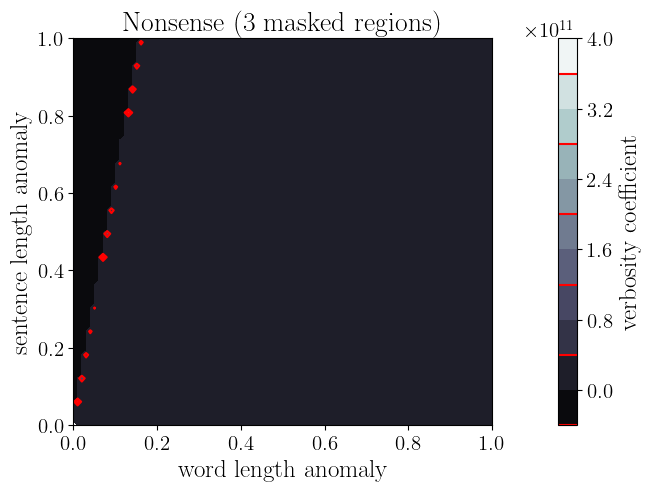

In [17]:
alphas = np.linspace(0, 1, 100)

Zvalues = []
Yvalues = []
X, Y = np.meshgrid(alphas, alphas)
Z = np.zeros((len(alphas), len(alphas)))



for i in range(100):
    for j in range(100):
        z = omega_gen_proj.flatten() + X[i,j] * vectors[0]
        y = omega_gen_proj_forced.flatten() + Y[i,j] * vectors[1]

        Z[i,j] = mdp.evaluate_allocation((z+y).reshape(ns,na))
    
fig1, ax2 = plt.subplots(constrained_layout=True)
CS = ax2.contourf(X, Y, Z, 10, cmap=plt.cm.bone)
CS2 = ax2.contour(CS, levels=CS.levels[::2], colors='r')

ax2.set_title('Nonsense (3 masked regions)')
ax2.set_xlabel('word length anomaly')
ax2.set_ylabel('sentence length anomaly')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('verbosity coefficient')
# Add the contour line levels to the colorbar
cbar.add_lines(CS2)


In [20]:
P = np.random.dirichlet(np.ones(ns), size=(ns, na))
R = np.random.dirichlet(np.ones(ns), size=(ns, na))
mdp = MDPDescription2(P, R, discount_factor, 1)

for theta in [0.1, 0.5, 1, 5, 10, 50, 100]:
    soft_policy = mdp.compute_optimal_soft_policy(0.99, theta)[1]

    omega_soft = compute_stationary_distribution(soft_policy, P)

    print(mdp.evaluate_allocation(omega_soft))

3435264348423.9917
3424379087686.975
3423015337614.499
3421923815183.5796
3421787341901.5503
3421678157972.495


KeyboardInterrupt: 

In [15]:
1/np.log(na)

0.36926937306885504